<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
# !pip install datasets

Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [5]:
# Загрузим датасет
dataset = load_dataset('imdb')

  0%|          | 0/3 [00:00<?, ?it/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [6]:
dataset.keys()

dict_keys(['train', 'test', 'unsupervised'])

In [7]:
dataset['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [8]:
sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences
for sentence in tqdm(dataset['train']['text']):
    sentences.extend([x.lower() for x in sent_tokenize(sentence, language='english') if len(word_tokenize(x)) < word_threshold])

  0%|          | 0/25000 [00:00<?, ?it/s]

In [9]:
print("Всего предложений:", len(sentences))

Всего предложений: 198756


Посчитаем для каждого слова его встречаемость.

In [12]:
from functools import reduce
import itertools
from collections import Counter
words = Counter(j for j in itertools.chain.from_iterable(tqdm(word_tokenize(i) for i in sentences)))
words.most_common(5)

# Расчет встречаемости слов

0it [00:00, ?it/s]

[('.', 170550), ('the', 151411), (',', 114297), ('a', 75305), ('and', 73199)]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [13]:
vocab = set()
vocab_size = 40000
for i in words.most_common(vocab_size):
    vocab.add(i[0])
# Наполнение словаря

In [14]:
vocab.add('<unk>')
vocab.add('<bos>')
vocab.add('<eos>')
vocab.add('<pad>')


In [15]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [16]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [17]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [37]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in word_tokenize(self.data[idx])] 
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)
    


In [38]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [39]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [40]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [46]:
import copy
def train(
    model,
    criterion,
    optimizer,
    train_dataloader,
    eval_dataloader,
    num_epoch = 5
):
    losses = []
    perplexities = []
    best_model = None

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(
                logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            
        model.eval()
        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities.append(evaluate(model, criterion, eval_dataloader))
        print(f'Perplexity on epoch {epoch}: {perplexities[-1]}')
        if len(perplexities)>1 and perplexities[-1] < perplexities[-2]:
            print('saving the best model')
            best_model = copy.deepcopy(model)
        
    return losses, perplexities, best_model.to('cpu')

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

# Возьмем модель из практики 

In [48]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [49]:
model = LanguageModel(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
losses1, perplexities1, model1 = train(model, criterion, optimizer, train_dataloader, eval_dataloader, num_epoch = 4)

Training epoch 0::   0%|          | 0/1243 [00:00<?, ?it/s]

Perplexity on epoch 0: 128.66954241817675


Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Perplexity on epoch 1: 97.98539619985849
saving the best model


Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Perplexity on epoch 2: 84.75790434239607
saving the best model


Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Perplexity on epoch 3: 76.43594150224094
saving the best model


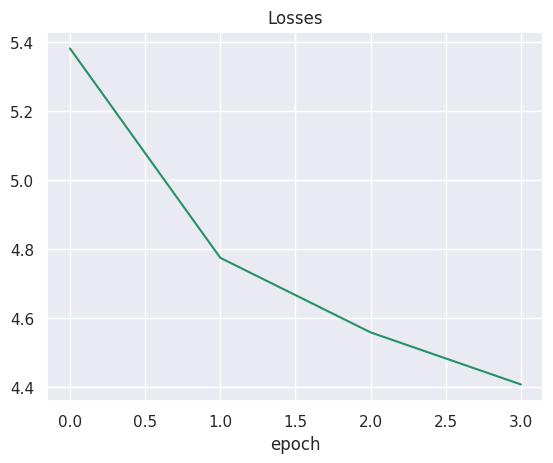

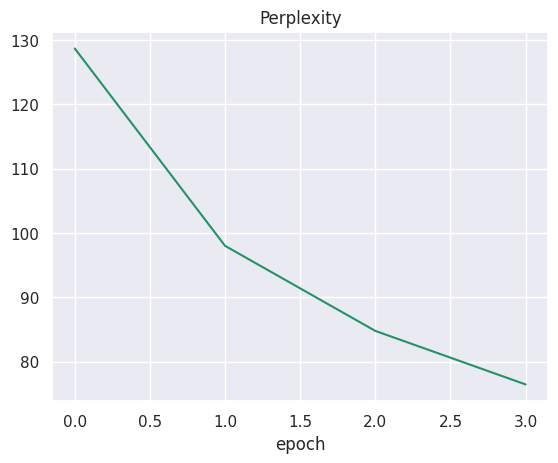

In [50]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(losses1)), losses1)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()
plt.plot(np.arange(len(perplexities1)), perplexities1)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

# Видим как падает перплексия, можно увеличить количество эпох

In [51]:
import gc
import torch 
model = None 
optimizer = None
torch.cuda.empty_cache()
gc.collect()



6863

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

# Заменим GRU на LSTM

In [54]:
class LanguageModelLSTM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=1)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [55]:
model = LanguageModelLSTM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
losses2, perplexities2, model2 = train(model, criterion, optimizer, train_dataloader, eval_dataloader, num_epoch = 6)

Training epoch 0::   0%|          | 0/1243 [00:00<?, ?it/s]

Perplexity on epoch 0: 131.34903891819937


Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Perplexity on epoch 1: 99.41812979208457
saving the best model


Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Perplexity on epoch 2: 84.6168208275676
saving the best model


Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Perplexity on epoch 3: 76.18963640721148
saving the best model


Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Perplexity on epoch 4: 70.12344747712713
saving the best model


Training epoch 5::   0%|          | 0/1243 [00:00<?, ?it/s]

Perplexity on epoch 5: 65.28186153966641
saving the best model


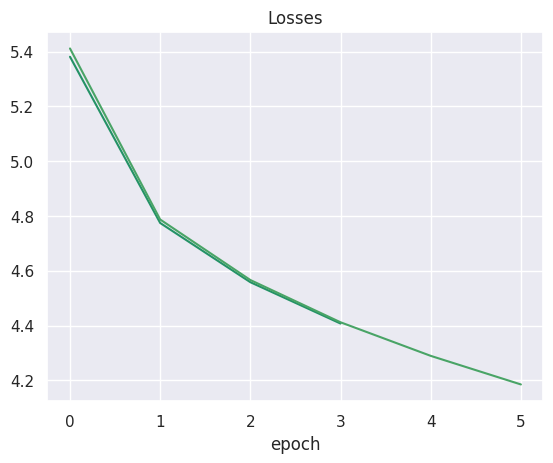

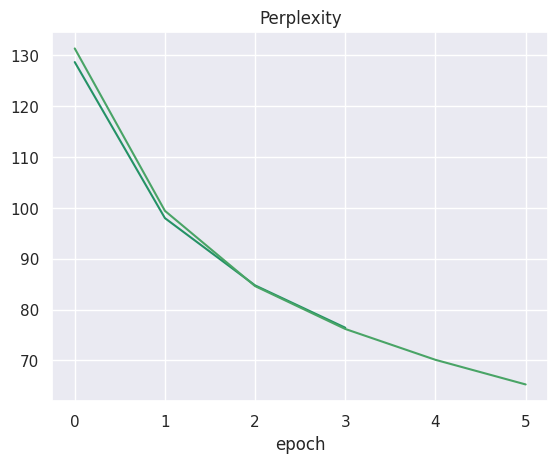

In [56]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(losses1)), losses1,label='1')
plt.plot(np.arange(len(losses2)), losses2,label='2')
plt.title('Losses')
plt.xlabel("epoch")
plt.show()
plt.plot(np.arange(len(perplexities1)), perplexities1,label='1')
plt.plot(np.arange(len(perplexities2)), perplexities2,label='2')
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [57]:
model = None 
optimizer = None
torch.cuda.empty_cache()
gc.collect()

7226

# увеличем скрытый слой, так как, vocab, довольно большой 

In [58]:
model = LanguageModelLSTM(hidden_dim=512, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
losses3, perplexities3, model3 = train(model, criterion, optimizer, train_dataloader, eval_dataloader, num_epoch = 6)

Training epoch 0::   0%|          | 0/1243 [00:00<?, ?it/s]

Perplexity on epoch 0: 101.97329165975407


Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Perplexity on epoch 1: 74.82564259925557
saving the best model


Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Perplexity on epoch 2: 62.34312947100194
saving the best model


Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Perplexity on epoch 3: 54.23429822983122
saving the best model


Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Perplexity on epoch 4: 48.3260660650187
saving the best model


Training epoch 5::   0%|          | 0/1243 [00:00<?, ?it/s]

Perplexity on epoch 5: 44.17183203678794
saving the best model


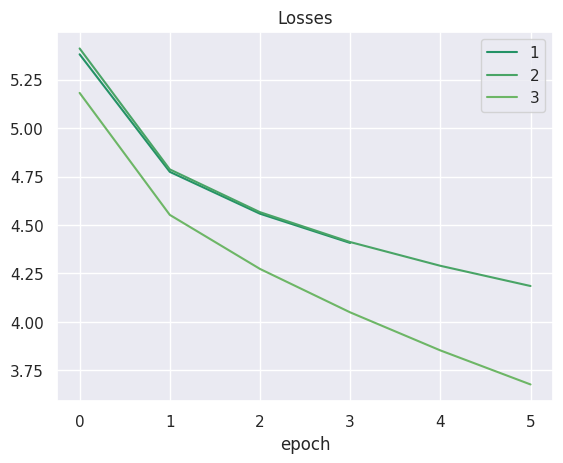

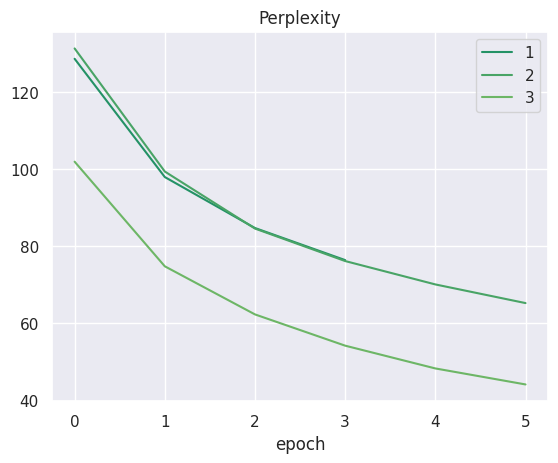

In [60]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(losses1)), losses1,label='1')
plt.plot(np.arange(len(losses2)), losses2,label='2')
plt.plot(np.arange(len(losses3)), losses3,label='3')
plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()
plt.plot(np.arange(len(perplexities1)), perplexities1,label='1')
plt.plot(np.arange(len(perplexities2)), perplexities2,label='2')
plt.plot(np.arange(len(perplexities3)), perplexities3,label='3')
plt.title('Perplexity')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [62]:
print(f"{min(perplexities1)}\n{min(perplexities2)}\n{min(perplexities3)}")

76.43594150224094
65.28186153966641
44.17183203678794


In [65]:
model3 = model3.to(device)
evaluate(model3, criterion, test_dataloader)

44.190743283108546

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

Замена GRU на LSTM ничего не дала, лишь не значительное понижение преплексии, по графикам видно, что модели не достигли даже плато обучения, следовательно, можно  увеличить количество эпох\
\
Весомы вклад дало увелечения размера скрытого слоя так как, ембединг довольно большой и закодировать его из 40_000 в 512 легче ,чем из  из 40_000 в 256

GRU 256 4 эпохи = 76.43594150224094\
LSTM 256 6 эпохи =  65.28186153966641\
LSTM 512 6 эпохи = 44.17183203678794

# Результаты на тесте LSTM 512 6 эпохи 44.190743283108546